<a href="https://colab.research.google.com/github/juandesages/PDI.Entregas/blob/main/TPN6/TPN6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practico TP6 (Convolución)
Implementar un aplicativo que levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución para los siguientes filtros:
1. Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
2. Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
3. Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4
Respecto del “cierre” de la imagen cerca de los bordes, implementar la técnica no matemáticamente perfecta de “repetir” artificialmente filas o columnas cuando estas hagan falta. Por ejemplo, si el kernel es 3x3 y estoy en la primera columna, y no hay ninguna columna a la izquierda, entonces repito la primera columna como si estuviese en la imagen original. Otra opción es la conocida como padding en la cual adicionamos filas y columnas de ceros en los extremos de la imagen, similar al que les mostré para hacer que dos imágenes tengan el mismo tamaño.
Deben mostrar el aplicativo que permita cargar o seleccionar la imagen y elegir de una lista el filtro a aplicar ver su resultado. Adicionalmente deben mostrar un plot con todos los filtros aplicados para la imagen de entrada.
Nota: La función de convolución debe ser desarrollada por ustedes, NO mediante funciones de biblioteca.


In [1]:
import imageio
import numpy as np 
from scipy import fftpack
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#--------- TPN 1 ---------
#Cargar imagen
def load_image(filename):
    #im_in=np.clip(imageio.imread(filename),0,255).astype(np.float)/255. 
    im_in= np.clip(imageio.imread(filename)/255.,0.,1.).astype(np.float)
    #imagen normalizada
    im=np.zeros((*im_in.shape[:2],3))
    image_type = 'RGB'
    if len(im_in.shape)==2: # la imagen es de tipo grayscale
        for i in range (3):
            im[:,:,i]=im_in
            image_type = 'grayscale'
    elif (im_in.shape[2]==4):
        im=im_in[:,:,:3]
        image_type = 'RGBA'
    elif im_in.shape==im.shape:
        im=im_in
    return im, image_type

#obtener información de la imagen
def get_data(im, im_type):
  if im_type == 'grayscale':
    h,w, ch = im.shape
    ch = 1
  else:
    h,w, ch = im.shape
  return h,w,ch #height, wide, channels

#guardar imagen
def save_image(im, title):
  im = im*255
  imageio.imwrite(title,im.astype(np.uint8))
  return 

#graficar imagen (mostrar imagen)
def show_image(im, title):
  plt.imshow(im)
  plt.title(title)
  plt.show()
  return 

#--------- TPN 2 ---------
#matriz para transformar de RGB a YIQ
MAT_YIQ = np.array([[0.299, 0.595716, 0.211456],
                    [0.587, -0.274453, -0.522591],
                    [0.114, -0.321263, 0.311135]])
#funcion para pasar una imagen RGB a YIQ
def rgb2yiq(_im):
    _yiq = np.matmul(_im.reshape((-1,3)), MAT_YIQ).reshape(_im.shape)
    return _yiq
#funcion para modificar valores de Y y de IQ
def scale_yiq(_yiq, alpha, beta):
    _yiq[:, :, 0] *= alpha
    _yiq[:, :, 1:3] *= beta   
    return _yiq
#funcion para pasar la imagen de YIQ a RGB
def yiq2rgb(_yiq):
    _rgb = np.matmul(_yiq.reshape((-1,3)),np.linalg.inv(MAT_YIQ)).reshape(_yiq.shape)
    return _rgb

def clip_rgb(rgb):
  return np.clip(rgb, a_min=[0,-0, 0], a_max=[255, 255, 255])

def clip_yiq(yiq):
  return np.clip(yiq, a_min=[0,-0.5957, -0.5226], a_max=[1, 0.5957, 0.5226])

#--------- TPN 3 ---------

def padding(im1, im2):
  f1,c1, _ = im1.shape
  f2,c2, _ = im2.shape
  if f1>f2: fmax = f1
  else: fmax = f2
  if c1>c2: cmax = c1
  else: cmax = c2
  im1_new = np.zeros((fmax,cmax,3), dtype='float')
  im2_new = np.copy(im1_new)
  im1_new[:f1,:c1,:] = im1[:,:,:]
  im2_new[:f2,:c2,:] = im2[:,:,:]
  return im1_new, im2_new
#--------- TPN5 -------------
def fft2_ap(im):
    im_f = np.fft.fftshift(np.fft.fft2(im))
    amp = np.abs(im_f)
    phase = np.angle(im_f)
    # amplitud normalizada:
    s = np.array(im.shape).prod()
    amp /= s
    return amp, phase

def ifft2_ap(amp, phase):
    s = np.array(amp.shape).prod()
    im_f = s * amp * (np.cos(phase)+1j *np.sin(phase))
    im = np.fft.ifft2(np.fft.ifftshift(im_f))
    return im.real
# guardar mapa de bits en png
def ap_to_8bit(amp, phase, fac = 2**24):
    amp_8bit = np.round((np.log(amp*fac+1)/np.log(fac+1)*(2**8))).astype(np.uint8)
    phase_8bit = ((phase/np.pi+1)/2 * 2**8).astype(np.uint8)
    return amp_8bit, phase_8bit

# leer mapa de bits desde un png
def ap_from_8bit(amp_8bit, phase_8bit, fac= 2**24):
    amp = (np.exp(amp_8bit / (2**8) * np.log(fac+1))-1)/fac
    phase = (phase_8bit / 2**8 * 2 - 1)*np.pi
    return amp, phase

#--------- TPN 4 ---------

#--------- TPN 5 ---------

#--------- TPN 6 ---------

def kernel_plot(data):
    s = data.shape
    y, x = np.meshgrid(np.arange(s[0]),np.arange(s[1]),indexing='ij')
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    _min = np.min(data)
    _max = np.max(data)
    ax.plot_surface(x,y,data.T,vmin=_min,vmax=_max)

def convolution(image, kernel = np.ones((1,1))):
    convolved = np.zeros((np.array(image.shape)-np.array(kernel.shape)+1))
    for x, y in np.ndindex(convolved.shape):
        convolved[x,y] = (image[x:x+kernel.shape[0],y:y+kernel.shape[1]]*kernel).sum()
    return convolved
def plain (s=7):
  k = np.ones((s,s))
  return k / k.sum()

def bartlett(s=3):
    a = (s+1)//2-np.abs(np.arange(s)-s//2)
    k = np.outer(a,a.T)
    return k / k.sum()

def gauss(s=3,scale=1):
    g = signal.gaussian(s,scale)
    k = np.outer(g,g.T)
    return k / k.sum()

def box(s=3,scale = None):
    if scale is None:
        scale = s
    padl = (s-scale)//2
    padr = (s-scale)-padl
    k = np.pad(np.ones((s,s)),(padl,padr))
    return k / k.sum()

def circle(s=3,scale=None,n=10):
    if scale is None:
        scale = s
    a = np.linspace(-1+1/(s*n),1-1/(s*n),s*n) *  s / scale 
    sel = ((a[:, np.newaxis]**2 + a[np.newaxis, :]**2)<=1)*1.0
    k = np.zeros((s,s))
    for x in range(s):
        for y in range(s):
            k[y,x] = (sel[y*n:(y+1)*n,x*n:(x+1)*n]).sum()
    return k / k.sum()

def laplace(_type=4,normalize=False):
    if _type==4:
        k =  np.array([[0.,-1.,0.],[-1.,4.,-1.],[0.,-1.,0.]])
    if _type==8:
        k =  np.array([[-1.,-1.,-1.],[-1.,8.,-1.],[-1.,-1.,-1.]])
    if normalize:
        k /= np.sum(np.abs(k))
    return k

def pascal(s=3):
    def pascal_triangle(steps,last_layer = np.array([1])):
        if steps==1:
            return last_layer
        next_layer = np.array([1,*(last_layer[:-1]+last_layer[1:]),1])
        return pascal_triangle(steps-1,next_layer)
    a = pascal_triangle(s)
    k = np.outer(a,a.T)
    return k / k.sum()

def diff_kernel(kernel_in,normalized = False):
    s = kernel_in.shape
    w_x =np.arange(-(s[1]-1)/2,s[1]/2)
    w_y =np.arange(-(s[0]-1)/2,s[0]/2)
    y,x = np.meshgrid(w_y,w_x,indexing='ij')
    k_x = kernel_in * x
    k_y = kernel_in * y
    if normalized:
        k_x /= np.abs(k_x).sum()
        k_y /= np.abs(k_y).sum()
    return (k_x, k_y)

def sobel(s=3):
    return diff_kernel(pascal(s))

def identity_kernel(s):
    kernel = np.zeros(s)
    kernel[s[0]//2,s[1]//2] = 1.
    return kernel
    
def high_pass(low_pass):
    return identity_kernel(low_pass.shape) - low_pass

def dog(size,fs=1,cs=2):
    return gauss(size,fs)-gauss(size,cs)

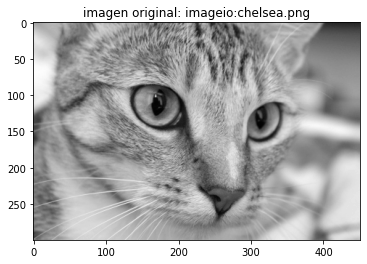

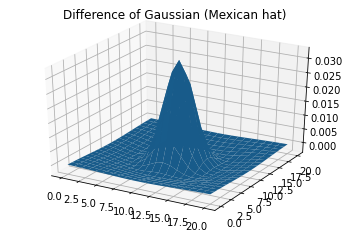

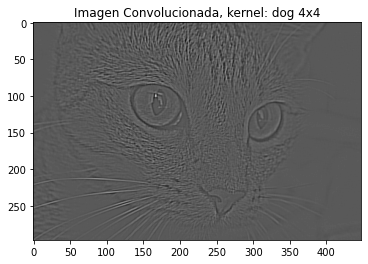

In [54]:
#@title _Cargar imagen_ seleccione la imagen a la que desea obtener el histograma y los bins del histogramarealizar la Transformada de fourier

imagen = 'imageio:chelsea.png'  #@param ['imageio:astronaut.png','imageio:camera.png','imageio:checkerboard.png', 'imageio:chelsea.png', 'imageio:coffee.png','imageio:wikkie.png']
kernel = 'dog' #@param ['plain','bartlett', 'gauss', 'laplace', 'sobel', 'high_pass', 'dog' ]
size = 4 #@param {type:"slider", min:1, max: 15, step:1}
im, im_type = load_image(imagen)
#im = np.clip(imageio.imread(imagen)/255.,0.,1.)
if im_type != 'grayscale':
  _im = rgb2yiq(im)
  im = _im[:,:,0]



plt.imshow(im,'gray')
plt.title('imagen original: '+str(imagen))
plt.show()

if kernel == 'plain':
  kernel_plot(plain(51))
  plt.title('Plain')
  plt.savefig('kernel: '+str(kernel)+'.png')
  plt.show()
  plt.imshow(convolution(im,plain(size)),'gray')
  plt.title('Imagen Convolucionada, kernel: '+str(kernel)+' '+str(size)+'x'+str(size))
  plt.savefig(str(imagen)+'kernel: '+str(kernel)+' '+str(size)+'x'+str(size)+'.png')
  plt.show()

if kernel == 'bartlett':
  kernel_plot(bartlett(51))
  plt.title('Bartlett')
  plt.savefig('kernel: '+str(kernel)+'.png')
  plt.show()
  plt.imshow(convolution(im,bartlett(size)),'gray')
  plt.title('Imagen Convolucionada, kernel: '+str(kernel)+' '+str(size)+'x'+str(size))
  plt.savefig(str(imagen)+'kernel: '+str(kernel)+' '+str(size)+'x'+str(size)+'.png')
  plt.show()

if kernel == 'gauss':
  kernel_plot(gauss(51))
  plt.title('Gauss')
  plt.savefig('kernel: '+str(kernel)+'.png')
  plt.show()
  plt.imshow(convolution(im,gauss(size)),'gray')
  plt.title('Imagen Convolucionada, kernel: '+str(kernel)+' '+str(size)+'x'+str(size))
  plt.savefig(str(imagen)+'kernel: '+str(kernel)+' '+str(size)+'x'+str(size)+'.png')
  plt.show()

if kernel == 'laplace':
  if size == 4 or size == 8: 
    kernel_plot(laplace(size))
    plt.title('Laplace')
    plt.savefig('kernel: '+str(kernel)+'.png')
    plt.show()
    plt.imshow(convolution(im,laplace(size)),'gray')
    plt.title('Imagen Convolucionada, kernel: '+str(kernel)+' '+str(size)+'x'+str(size))
    plt.savefig(str(imagen)+'kernel: '+str(kernel)+' '+str(size)+'x'+str(size)+'.png')
    plt.show()

if kernel == 'sobel':
  kernel_plot(sobel(51))
  plt.title('sobel')
  plt.savefig('kernel: '+str(kernel)+'.png')
  plt.show()
  plt.imshow(convolution(im,sobel(size)),'gray')
  plt.title('Imagen Convolucionada, kernel: '+str(kernel)+' '+str(size)+'x'+str(size))
  plt.savefig(str(imagen)+'kernel: '+str(kernel)+' '+str(size)+'x'+str(size)+'.png')
  plt.show()

if kernel == 'dog':
  kernel_plot(_dog)
  plt.title('Difference of Gaussian (Mexican hat)')
  plt.savefig('kernel: '+str(kernel)+'.png')
  plt.show()
  plt.imshow(convolution(im,dog(size,2,5)),'gray')
  plt.title('Imagen Convolucionada, kernel: '+str(kernel)+' '+str(size)+'x'+str(size))
  plt.savefig(str(imagen)+'kernel: '+str(kernel)+' '+str(size)+'x'+str(size)+'.png')
  plt.show()

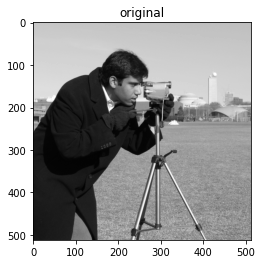

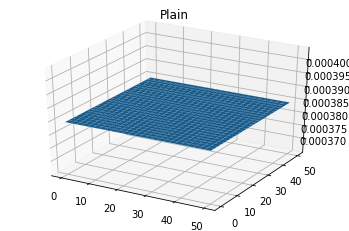

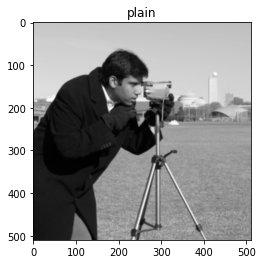

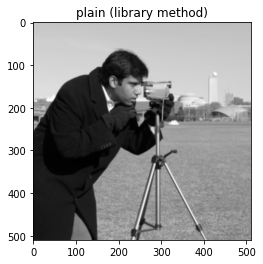

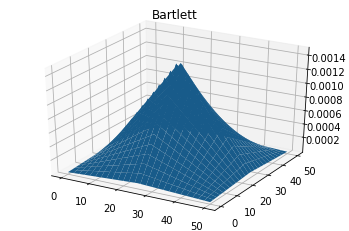

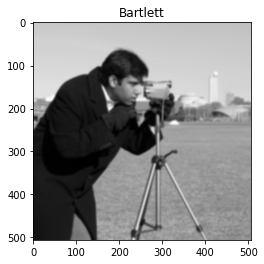

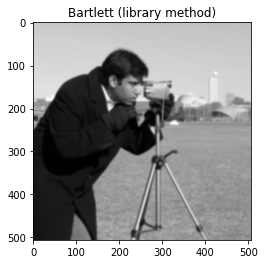

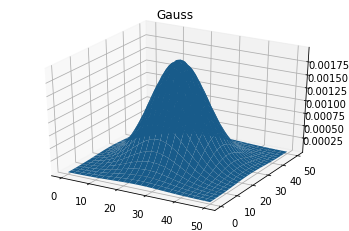

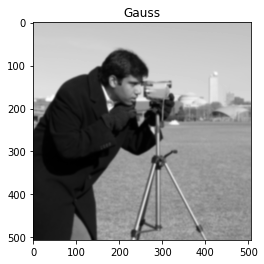

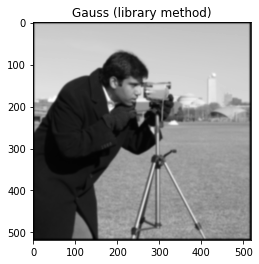

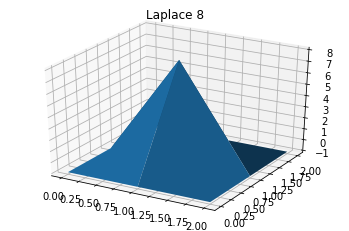

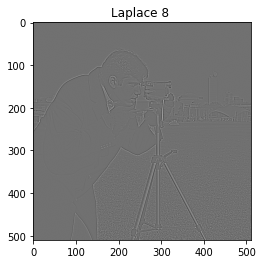

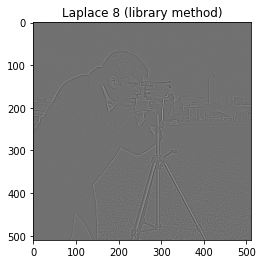

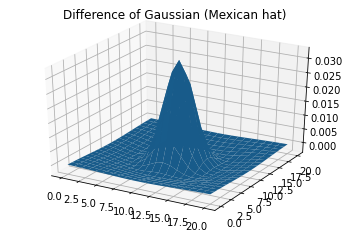

NameError: ignored

In [40]:
im = imageio.imread('imageio:camera.png')/255.

plt.imshow(im,'gray')
plt.title('original')
plt.show()

kernel_plot(plain(51))
plt.title('Plain')
plt.show()

plt.imshow(convolution(im,plain(3)),'gray')
plt.title('plain')
plt.show()

plt.imshow(signal.convolve(im,plain(3), 'valid'),'gray')
plt.title('plain (library method)')
plt.show()

kernel_plot(bartlett(51))
plt.title('Bartlett')
plt.show()

plt.imshow(convolution(im,bartlett(7)),'gray')
plt.title('Bartlett')
plt.show()

plt.imshow(signal.convolve(im,bartlett(7), 'valid'),'gray')
plt.title('Bartlett (library method)')
plt.show()

kernel_plot(gauss(51,9))
plt.title('Gauss')
plt.show()
plt.imshow(convolution(im,gauss(7,1.6)),'gray')
plt.title('Gauss')
plt.show()

plt.imshow(signal.convolve(im,gauss(7,1.6)),'gray')
plt.title('Gauss (library method)')
plt.show()

kernel_plot(laplace(8))
plt.title('Laplace 8')
plt.show()

plt.imshow(convolution(im, laplace(8)),'gray')
plt.title('Laplace 8 ')
plt.show()

plt.imshow(signal.convolve(im, laplace(8), 'valid'),'gray')
plt.title('Laplace 8 (library method)')
plt.show()

_dog = dog(21,2,5)
kernel_plot(_dog)
plt.title('Difference of Gaussian (Mexican hat)')
plt.show()

plt.imshow(convolve(im,_dog, 'valid'),'gray')
plt.title('Bandpass (Mexican hat)')
plt.show()

kernel_plot(sobel(21)[0])
plt.title('Sobel x')
plt.show()

plt.imshow(convolution(im,sobel(5)[0]),'gray')
plt.title('Sobel x')
plt.show()

plt.imshow(convolution(im,sobel(5)[1]),'gray')
plt.title('Sobel y')
plt.show()